In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
import os
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-09-08 01:19:44.211075: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 01:19:44.244928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 01:19:44.794334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [3]:
file = '2013~2023 한국 기온,습도,풍속.csv'
file2 = '한국기후 평균 최고 최저.csv'

In [4]:
df = pd.read_csv(file, encoding = 'cp949')
df1 = pd.read_csv(file2, encoding = 'cp949', header = 0)
df1.head()

,\t\t지점번호,지점명,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,105,강릉,1970-01-01,3.2,10.3,-0.5
1,105,강릉,1970-01-02,1.8,5.1,-0.2
2,105,강릉,1970-01-03,-0.3,4.8,-2.2
3,105,강릉,1970-01-04,-5.9,-1.7,-12.6
4,105,강릉,1970-01-05,-7.9,-0.8,-14.7


In [5]:
df1.columns = ['지점번호', '지점명', '일시', '평균기온(℃)', '최고기온(℃)', '최저기온(℃)']
df1 = df1.iloc[:, 2:]
df1.head()

,일시,평균기온(℃),최고기온(℃),최저기온(℃)
0,1970-01-01,3.2,10.3,-0.5
1,1970-01-02,1.8,5.1,-0.2
2,1970-01-03,-0.3,4.8,-2.2
3,1970-01-04,-5.9,-1.7,-12.6
4,1970-01-05,-7.9,-0.8,-14.7


In [6]:
df_korea = df.drop(['지점번호', '지점명'], axis = 1).groupby(['일시']).mean()
df_temp = df1.groupby(['일시']).mean()
df_korea.head(10)

,평균기온(℃),최고기온(℃),최저기온(℃),평균습도(%rh),평균풍속(m/s)
일시,,,,,
2013-01-01,-0.76250,4.43750,-6.21250,73.10000,2.33125
2013-01-02,-4.70000,0.54375,-8.98125,53.29375,3.58750
2013-01-03,-8.09375,-3.99375,-11.26250,48.90000,3.40625
2013-01-04,-6.74375,-1.15000,-11.61875,50.25000,2.03125
2013-01-05,-3.81250,1.75625,-9.41875,57.06250,2.28125
2013-01-06,-2.32500,2.52500,-5.73750,57.04375,1.96875
2013-01-07,-2.00625,3.35000,-6.72500,49.62500,1.95000
2013-01-08,-1.22500,3.76875,-5.28750,50.66250,2.15625
2013-01-09,-4.01875,-0.80625,-7.14375,45.38125,3.41250


In [7]:
filter1 = df_temp['최고기온(℃)'].isna() == True
df_temp['최고기온(℃)'][filter1] = 20.787

In [8]:
filter2 = df_temp['최저기온(℃)'].isna() == True
df_temp['최저기온(℃)'][filter2] = 7.15625

In [9]:
df_korea = df_korea.reset_index()

In [10]:
df_korea['일시']  = pd.to_datetime(df_korea['일시'])
df_korea.set_index('일시', inplace = True)

In [11]:
dataset = df_temp.iloc[:, :]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(19585, 3)

In [12]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
print('Train Size :', train_size, 'Test Size : ', test_size)

Train Size : 15668 Test Size :  3917


In [13]:
scaler = MinMaxScaler(feature_range = (0 , 1))
scaled_data = scaler.fit_transform(np.array(data))

In [14]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(15668, 3)

In [15]:
x_train = []
y_train = []
time_step = 65
n_col = 3

for i in range(time_step, len(scaled_data)):
    print(time_step, i)
    x_train.append(scaled_data[i-time_step:i, :n_col])
    y_train.append(scaled_data[i, :n_col])
    if i <= time_step:
        print('x_train : ', x_train)
        print('y_train : ', y_train)

65 65
x_train :  [array([[0.28644888, 0.31922063, 0.28660807],
       [0.29945554, 0.29607384, 0.3198272 ],
       [0.25937689, 0.25388222, 0.26530612],
       [0.10027223, 0.10108409, 0.08580366],
       [0.02510587, 0.04731907, 0.        ],
       [0.24319419, 0.25754468, 0.20527335],
       [0.22837266, 0.23513038, 0.23596008],
       [0.23835451, 0.25388222, 0.23447043],
       [0.17211131, 0.16319953, 0.18948309],
       [0.20220811, 0.21432757, 0.19603754],
       [0.23275862, 0.25212423, 0.2215105 ],
       [0.33318209, 0.35159684, 0.2919708 ],
       [0.15366001, 0.17096396, 0.17488455],
       [0.09195402, 0.10225608, 0.10859526],
       [0.06488203, 0.05288602, 0.09742291],
       [0.05792498, 0.08980369, 0.04856249],
       [0.0738052 , 0.09449165, 0.07239684],
       [0.12885662, 0.18678582, 0.1084463 ],
       [0.17029643, 0.20773513, 0.16803218],
       [0.1822444 , 0.22121301, 0.17116043],
       [0.22081065, 0.27175505, 0.194101  ],
       [0.28055051, 0.32390858, 0.248

65 3619
65 3620
65 3621
65 3622
65 3623
65 3624
65 3625
65 3626
65 3627
65 3628
65 3629
65 3630
65 3631
65 3632
65 3633
65 3634
65 3635
65 3636
65 3637
65 3638
65 3639
65 3640
65 3641
65 3642
65 3643
65 3644
65 3645
65 3646
65 3647
65 3648
65 3649
65 3650
65 3651
65 3652
65 3653
65 3654
65 3655
65 3656
65 3657
65 3658
65 3659
65 3660
65 3661
65 3662
65 3663
65 3664
65 3665
65 3666
65 3667
65 3668
65 3669
65 3670
65 3671
65 3672
65 3673
65 3674
65 3675
65 3676
65 3677
65 3678
65 3679
65 3680
65 3681
65 3682
65 3683
65 3684
65 3685
65 3686
65 3687
65 3688
65 3689
65 3690
65 3691
65 3692
65 3693
65 3694
65 3695
65 3696
65 3697
65 3698
65 3699
65 3700
65 3701
65 3702
65 3703
65 3704
65 3705
65 3706
65 3707
65 3708
65 3709
65 3710
65 3711
65 3712
65 3713
65 3714
65 3715
65 3716
65 3717
65 3718
65 3719
65 3720
65 3721
65 3722
65 3723
65 3724
65 3725
65 3726
65 3727
65 3728
65 3729
65 3730
65 3731
65 3732
65 3733
65 3734
65 3735
65 3736
65 3737
65 3738
65 3739
65 3740
65 3741
65 3742
65 3743


65 7503
65 7504
65 7505
65 7506
65 7507
65 7508
65 7509
65 7510
65 7511
65 7512
65 7513
65 7514
65 7515
65 7516
65 7517
65 7518
65 7519
65 7520
65 7521
65 7522
65 7523
65 7524
65 7525
65 7526
65 7527
65 7528
65 7529
65 7530
65 7531
65 7532
65 7533
65 7534
65 7535
65 7536
65 7537
65 7538
65 7539
65 7540
65 7541
65 7542
65 7543
65 7544
65 7545
65 7546
65 7547
65 7548
65 7549
65 7550
65 7551
65 7552
65 7553
65 7554
65 7555
65 7556
65 7557
65 7558
65 7559
65 7560
65 7561
65 7562
65 7563
65 7564
65 7565
65 7566
65 7567
65 7568
65 7569
65 7570
65 7571
65 7572
65 7573
65 7574
65 7575
65 7576
65 7577
65 7578
65 7579
65 7580
65 7581
65 7582
65 7583
65 7584
65 7585
65 7586
65 7587
65 7588
65 7589
65 7590
65 7591
65 7592
65 7593
65 7594
65 7595
65 7596
65 7597
65 7598
65 7599
65 7600
65 7601
65 7602
65 7603
65 7604
65 7605
65 7606
65 7607
65 7608
65 7609
65 7610
65 7611
65 7612
65 7613
65 7614
65 7615
65 7616
65 7617
65 7618
65 7619
65 7620
65 7621
65 7622
65 7623
65 7624
65 7625
65 7626
65 7627


65 11155
65 11156
65 11157
65 11158
65 11159
65 11160
65 11161
65 11162
65 11163
65 11164
65 11165
65 11166
65 11167
65 11168
65 11169
65 11170
65 11171
65 11172
65 11173
65 11174
65 11175
65 11176
65 11177
65 11178
65 11179
65 11180
65 11181
65 11182
65 11183
65 11184
65 11185
65 11186
65 11187
65 11188
65 11189
65 11190
65 11191
65 11192
65 11193
65 11194
65 11195
65 11196
65 11197
65 11198
65 11199
65 11200
65 11201
65 11202
65 11203
65 11204
65 11205
65 11206
65 11207
65 11208
65 11209
65 11210
65 11211
65 11212
65 11213
65 11214
65 11215
65 11216
65 11217
65 11218
65 11219
65 11220
65 11221
65 11222
65 11223
65 11224
65 11225
65 11226
65 11227
65 11228
65 11229
65 11230
65 11231
65 11232
65 11233
65 11234
65 11235
65 11236
65 11237
65 11238
65 11239
65 11240
65 11241
65 11242
65 11243
65 11244
65 11245
65 11246
65 11247
65 11248
65 11249
65 11250
65 11251
65 11252
65 11253
65 11254
65 11255
65 11256
65 11257
65 11258
65 11259
65 11260
65 11261
65 11262
65 11263
65 11264
65 11265
6

65 13671
65 13672
65 13673
65 13674
65 13675
65 13676
65 13677
65 13678
65 13679
65 13680
65 13681
65 13682
65 13683
65 13684
65 13685
65 13686
65 13687
65 13688
65 13689
65 13690
65 13691
65 13692
65 13693
65 13694
65 13695
65 13696
65 13697
65 13698
65 13699
65 13700
65 13701
65 13702
65 13703
65 13704
65 13705
65 13706
65 13707
65 13708
65 13709
65 13710
65 13711
65 13712
65 13713
65 13714
65 13715
65 13716
65 13717
65 13718
65 13719
65 13720
65 13721
65 13722
65 13723
65 13724
65 13725
65 13726
65 13727
65 13728
65 13729
65 13730
65 13731
65 13732
65 13733
65 13734
65 13735
65 13736
65 13737
65 13738
65 13739
65 13740
65 13741
65 13742
65 13743
65 13744
65 13745
65 13746
65 13747
65 13748
65 13749
65 13750
65 13751
65 13752
65 13753
65 13754
65 13755
65 13756
65 13757
65 13758
65 13759
65 13760
65 13761
65 13762
65 13763
65 13764
65 13765
65 13766
65 13767
65 13768
65 13769
65 13770
65 13771
65 13772
65 13773
65 13774
65 13775
65 13776
65 13777
65 13778
65 13779
65 13780
65 13781
6

65 16816
65 16817
65 16818
65 16819
65 16820
65 16821
65 16822
65 16823
65 16824
65 16825
65 16826
65 16827
65 16828
65 16829
65 16830
65 16831
65 16832
65 16833
65 16834
65 16835
65 16836
65 16837
65 16838
65 16839
65 16840
65 16841
65 16842
65 16843
65 16844
65 16845
65 16846
65 16847
65 16848
65 16849
65 16850
65 16851
65 16852
65 16853
65 16854
65 16855
65 16856
65 16857
65 16858
65 16859
65 16860
65 16861
65 16862
65 16863
65 16864
65 16865
65 16866
65 16867
65 16868
65 16869
65 16870
65 16871
65 16872
65 16873
65 16874
65 16875
65 16876
65 16877
65 16878
65 16879
65 16880
65 16881
65 16882
65 16883
65 16884
65 16885
65 16886
65 16887
65 16888
65 16889
65 16890
65 16891
65 16892
65 16893
65 16894
65 16895
65 16896
65 16897
65 16898
65 16899
65 16900
65 16901
65 16902
65 16903
65 16904
65 16905
65 16906
65 16907
65 16908
65 16909
65 16910
65 16911
65 16912
65 16913
65 16914
65 16915
65 16916
65 16917
65 16918
65 16919
65 16920
65 16921
65 16922
65 16923
65 16924
65 16925
65 16926
6

65 19344
65 19345
65 19346
65 19347
65 19348
65 19349
65 19350
65 19351
65 19352
65 19353
65 19354
65 19355
65 19356
65 19357
65 19358
65 19359
65 19360
65 19361
65 19362
65 19363
65 19364
65 19365
65 19366
65 19367
65 19368
65 19369
65 19370
65 19371
65 19372
65 19373
65 19374
65 19375
65 19376
65 19377
65 19378
65 19379
65 19380
65 19381
65 19382
65 19383
65 19384
65 19385
65 19386
65 19387
65 19388
65 19389
65 19390
65 19391
65 19392
65 19393
65 19394
65 19395
65 19396
65 19397
65 19398
65 19399
65 19400
65 19401
65 19402
65 19403
65 19404
65 19405
65 19406
65 19407
65 19408
65 19409
65 19410
65 19411
65 19412
65 19413
65 19414
65 19415
65 19416
65 19417
65 19418
65 19419
65 19420
65 19421
65 19422
65 19423
65 19424
65 19425
65 19426
65 19427
65 19428
65 19429
65 19430
65 19431
65 19432
65 19433
65 19434
65 19435
65 19436
65 19437
65 19438
65 19439
65 19440
65 19441
65 19442
65 19443
65 19444
65 19445
65 19446
65 19447
65 19448
65 19449
65 19450
65 19451
65 19452
65 19453
65 19454
6

In [16]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_col))

In [18]:
x_train.shape, y_train.shape

((19520, 65, 3), (19520, 3))

In [21]:
m_lstm = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(x_train.shape[1], n_col),
                       activation = 'relu',return_sequences = True),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(50, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'),
    keras.layers.LSTM(32, return_sequences = False, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(n_col)
])

m_lstm.summary()
#kernel_regularizer="l2"
#kernel_regularizer = keras.regularizers.l2(0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 65, 50)            10800     
                                                                 
 lstm_3 (LSTM)               (None, 65, 64)            29440     
                                                                 
 lstm_4 (LSTM)               (None, 65, 50)            23000     
                                                                 
 lstm_5 (LSTM)               (None, 65, 64)            29440     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)               

In [22]:
m_lstm.compile(optimizer = tf.optimizers.RMSprop(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [23]:
h = m_lstm.fit(x_train, y_train, epochs = 30, shuffle=False, batch_size = 32)

Epoch 1/30
610/610 [==============================] - 30s 45ms/step - loss: 0.0231 - mae: 0.1137
Epoch 2/30
610/610 [==============================] - 28s 46ms/step - loss: 0.0110 - mae: 0.0769
Epoch 3/30
610/610 [==============================] - 27s 45ms/step - loss: 340186144.0000 - mae: 2062.2896
Epoch 4/30
610/610 [==============================] - 25s 41ms/step - loss: 1852402.7500 - mae: 161.3969
Epoch 5/30
610/610 [==============================] - 25s 41ms/step - loss: 130169.2344 - mae: 23.2803
Epoch 6/30
610/610 [==============================] - 25s 41ms/step - loss: 145804.8750 - mae: 14.4710
Epoch 7/30
610/610 [==============================] - 25s 41ms/step - loss: 4602874880.0000 - mae: 8185.1338
Epoch 8/30
610/610 [==============================] - 25s 41ms/step - loss: 203179.8594 - mae: 91.1025
Epoch 9/30
610/610 [==============================] - 25s 41ms/step - loss: 3.6963 - mae: 0.2669
Epoch 10/30
610/610 [==============================] - 25s 41ms/step - loss: 0

Text(0, 0.5, 'Losses')

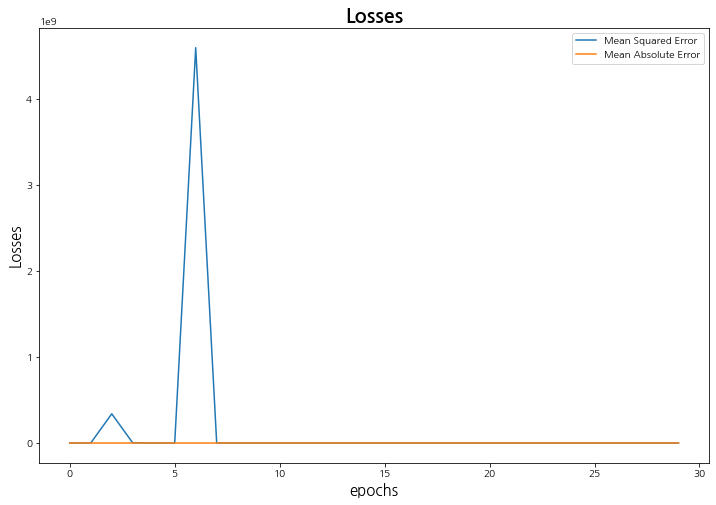

In [24]:
fig, axe = plt.subplots(figsize = (12, 8))
axe.plot(h.history['loss'])
axe.plot(h.history['mae'])
axe.legend(['Mean Squared Error', 'Mean Absolute Error'])
axe.set_title('Losses', size = 20, weight = 'bold')
axe.set_xlabel('epochs', size = 15)
axe.set_ylabel('Losses', size = 15)

In [25]:
#8/30
m_lstm.save('m7_lstm_RMSprop.h5')

In [26]:
m_lstm_RMSprop = tf.keras.models.load_model('m7_lstm_RMSprop.h5')

In [27]:
test_data = scaled_data[train_size - time_step:, :]

x_test = []
y_test = []

for i in range(time_step, len(test_data)):
    #print(time_step, i)
    x_test.append(test_data[i-time_step:i, 0:n_col])
    y_test.append(test_data[i, 0:n_col])
    
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_col))

x_test

array([[[0.74153055, 0.75124524, 0.72441531],
        [0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        ...,
        [0.39398064, 0.40375037, 0.36317593],
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439]],

       [[0.73623714, 0.73849985, 0.72918218],
        [0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        ...,
        [0.44570478, 0.46103135, 0.42633696],
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793]],

       [[0.74001815, 0.75197773, 0.71875466],
        [0.74894132, 0.7666276 , 0.72396842],
        [0.74863884, 0.76779959, 0.72605393],
        ...,
        [0.42105263, 0.3997949 , 0.45404439],
        [0.36448881, 0.37591562, 0.37583793],
        [0.3761343 , 0.3891005 , 0.34693878]],

       ...,

       [[0.7993043 , 0.80383827, 0.78370326],
        [0.81019359, 0.82346909, 0.80560107],
        [0.79748941, 0

In [28]:
m_lstm_RMSprop.evaluate(x_test, y_test)

123/123 [==============================] - 2s 15ms/step - loss: 0.0023 - mae: 0.0355


[0.0022902984637767076, 0.035524722188711166]

In [29]:
pred = m_lstm_RMSprop.predict(x_test)
pred

123/123 [==============================] - 2s 15ms/step


array([[0.38554677, 0.39888847, 0.37129647],
       [0.3524322 , 0.3651737 , 0.33946115],
       [0.37179682, 0.38526195, 0.35813403],
       ...,
       [0.87814   , 0.84975815, 0.8878176 ],
       [0.91544074, 0.8848853 , 0.9255802 ],
       [0.9157929 , 0.88565004, 0.9255317 ]], dtype=float32)

In [30]:
pred = scaler.inverse_transform(pred)
print(pred.shape)
pred

(3917, 3)


array([[ 5.4264703 , 10.267579  ,  1.0157073 ],
       [ 4.0580106 ,  8.829223  , -0.3199832 ],
       [ 4.8582535 ,  9.686238  ,  0.46346095],
       ...,
       [25.782885  , 29.502808  , 22.686998  ],
       [27.324339  , 31.001421  , 24.271374  ],
       [27.33889   , 31.034046  , 24.269339  ]], dtype=float32)

In [31]:
y_test = scaler.inverse_transform(y_test)
y_test

array([[ 4.556250e+00,  9.287500e+00,  1.206250e+00],
       [ 5.037500e+00,  9.850000e+00, -6.250000e-03],
       [ 4.600000e+00,  8.412500e+00,  1.768750e+00],
       ...,
       [ 2.688750e+01,  3.100625e+01,  2.351875e+01],
       [ 2.740000e+01,  3.166250e+01,  2.434375e+01],
       [ 2.723750e+01,  3.121250e+01,  2.421250e+01]])

In [32]:
pred = pd.DataFrame(pred)
y_test = pd.DataFrame(y_test)

In [33]:
pred.columns = ['예측평균기온', '예측최고기온', '예측최저기온']
y_test.columns = ['실제평균기온', '실제최고기온', '실제최저기온']

In [34]:
df_pred = pd.concat((pred, y_test), axis = 1)
df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온', '예측최저기온', '실제최저기온']]
#df_pred = df_pred[['예측평균기온', '실제평균기온', '예측최고기온', '실제최고기온']]
df_pred

,예측평균기온,실제평균기온,예측최고기온,실제최고기온,예측최저기온,실제최저기온
0,5.426470,4.55625,10.267579,9.28750,1.015707,1.20625
1,4.058011,5.03750,8.829223,9.85000,-0.319983,-0.00625
2,4.858253,4.60000,9.686238,8.41250,0.463461,1.76875
3,4.130193,3.42500,8.905892,8.21875,-0.249505,-0.63750
4,3.371648,7.72500,8.100471,13.74375,-0.993879,1.75000
...,...,...,...,...,...,...
3912,24.696135,26.24375,28.438580,29.97500,21.571625,22.85625
3913,27.166878,25.86250,30.810001,29.23125,24.124811,23.14375
3914,25.782885,26.88750,29.502808,31.00625,22.686998,23.51875
3915,27.324339,27.40000,31.001421,31.66250,24.271374,24.34375


Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


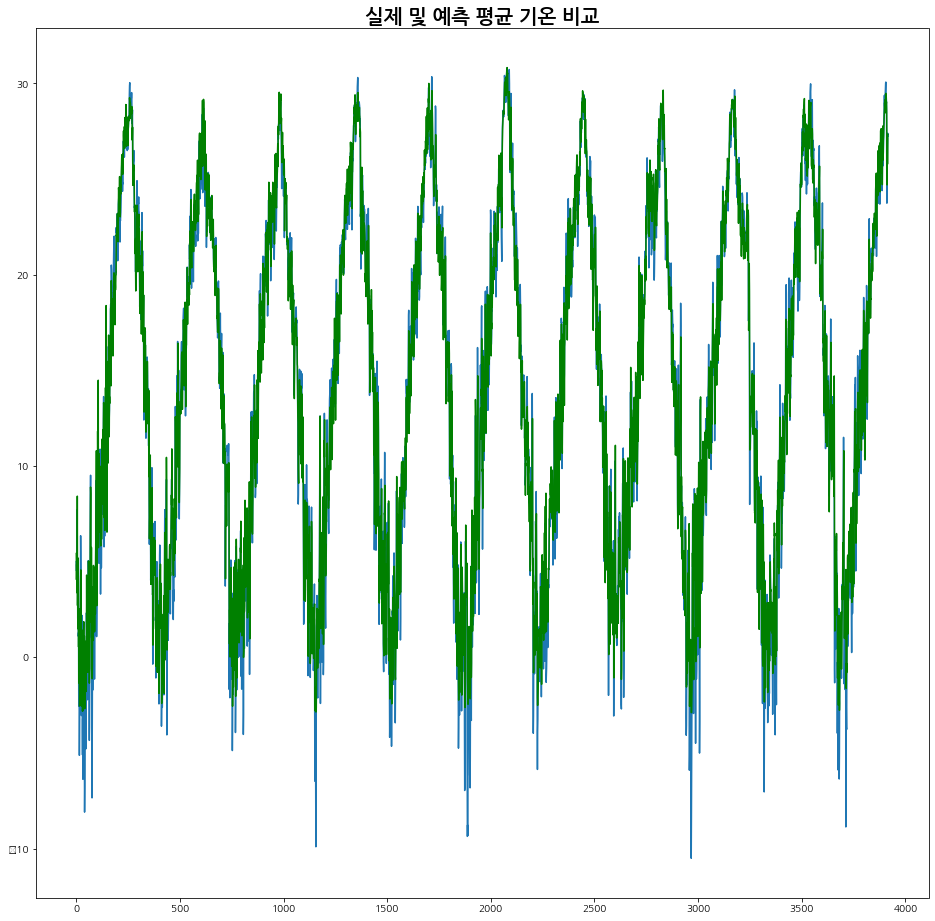

In [35]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제평균기온'])
axe.plot(df_pred['예측평균기온'], c = 'g')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

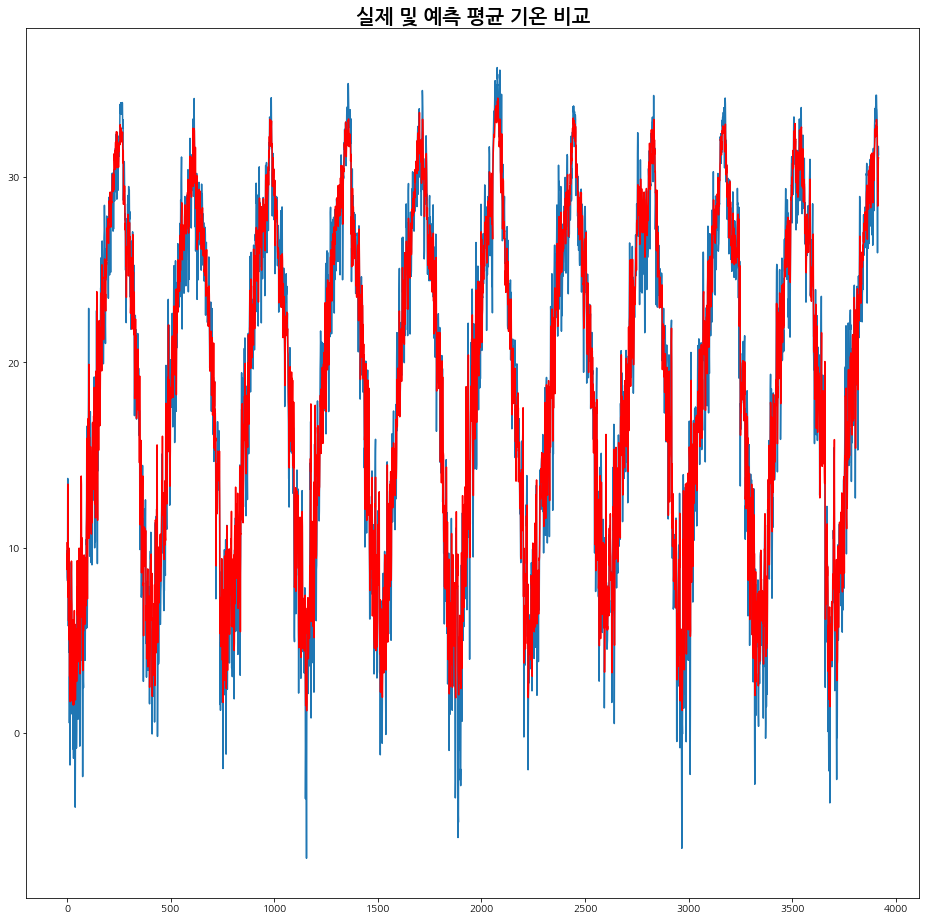

In [36]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최고기온'])
axe.plot(df_pred['예측최고기온'], c = 'r')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

Text(0.5, 1.0, '실제 및 예측 평균 기온 비교')

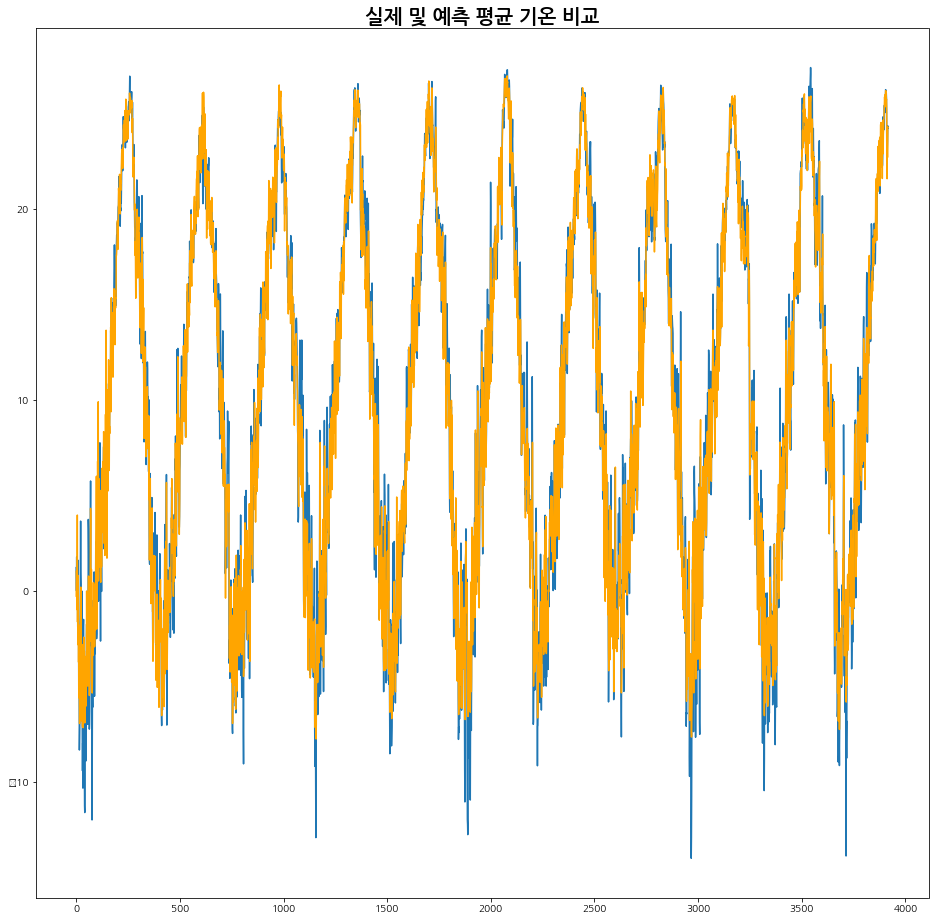

In [37]:
fig, axe = plt.subplots(figsize = (16, 16))
axe.plot(df_pred['실제최저기온'])
axe.plot(df_pred['예측최저기온'], c = 'orange')

axe.set_title('실제 및 예측 평균 기온 비교', size = 20, weight = 'bold')
#axe.legend(['actual', 'predict'])

In [38]:
start_date = datetime.date(2023, 8, 16)
#print('언제의 대한민국 평균 기온을 알고 싶으신가요? (Ex. 2040-01-01, 형태로 적어주세요)')
year, month, day = map(int, input().split('-'))
target_date = datetime.date(year, month, day)

d_day = (target_date - start_date).days
print(d_day)

2025-08-15
730


In [39]:
list(x_test[-1][0])

[0.7974894131881426, 0.7981248168766482, 0.799791449426486]

In [40]:
last_array = []
for i in range(len(x_test[-1])):
    last_array.append(list(x_test[-1][i]))
len(last_array)
np.array(last_array)

array([[0.79748941, 0.79812482, 0.79979145],
       [0.78750756, 0.78523293, 0.79055564],
       [0.78871748, 0.77717551, 0.79413079],
       [0.77208106, 0.77234105, 0.7729778 ],
       [0.77283727, 0.77658951, 0.75495308],
       [0.82320024, 0.8448579 , 0.77387159],
       [0.84664247, 0.86595371, 0.81438999],
       [0.85012099, 0.86346323, 0.84120363],
       [0.85904416, 0.87884559, 0.8286906 ],
       [0.81261343, 0.77981248, 0.82809474],
       [0.76149425, 0.70216818, 0.80470728],
       [0.80490018, 0.7890419 , 0.80902726],
       [0.82698125, 0.82127161, 0.82064651],
       [0.8399879 , 0.84207442, 0.83345747],
       [0.84497883, 0.83899795, 0.83837331],
       [0.83514822, 0.77131556, 0.85282288],
       [0.87008469, 0.84837386, 0.87308208],
       [0.84694495, 0.81380018, 0.85297185],
       [0.85344828, 0.78757691, 0.89423507],
       [0.82879613, 0.777322  , 0.87546551],
       [0.86358137, 0.85701729, 0.86757039],
       [0.88384755, 0.87503662, 0.88559511],
       [0.

In [41]:
for i in range(time_step, d_day+ time_step):
    print(time_step, i)
    last_ar = np.array(last_array)[i-time_step:i, 0:n_col]
    print(last_ar)
    array = np.reshape(last_ar, (1, last_ar.shape[0], n_col))
    print(array.shape)
    last_array.append(list(m_lstm_RMSprop.predict(array)[0]))
    print(len(last_array))

65 65
[[0.79748941 0.79812482 0.79979145]
 [0.78750756 0.78523293 0.79055564]
 [0.78871748 0.77717551 0.79413079]
 [0.77208106 0.77234105 0.7729778 ]
 [0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.8070612

1/1 [==============================] - 0s 19ms/step
69
65 69
[[0.77283727 0.77658951 0.75495308]
 [0.82320024 0.8448579  0.77387159]
 [0.84664247 0.86595371 0.81438999]
 [0.85012099 0.86346323 0.84120363]
 [0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0

(1, 65, 3)
1/1 [==============================] - 0s 18ms/step
73
65 73
[[0.85904416 0.87884559 0.8286906 ]
 [0.81261343 0.77981248 0.82809474]
 [0.76149425 0.70216818 0.80470728]
 [0.80490018 0.7890419  0.80902726]
 [0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92

1/1 [==============================] - 0s 21ms/step
77
65 77
[[0.82698125 0.82127161 0.82064651]
 [0.8399879  0.84207442 0.83345747]
 [0.84497883 0.83899795 0.83837331]
 [0.83514822 0.77131556 0.85282288]
 [0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0

1/1 [==============================] - 0s 20ms/step
81
65 81
[[0.87008469 0.84837386 0.87308208]
 [0.84694495 0.81380018 0.85297185]
 [0.85344828 0.78757691 0.89423507]
 [0.82879613 0.777322   0.87546551]
 [0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0

1/1 [==============================] - 0s 19ms/step
85
65 85
[[0.86358137 0.85701729 0.86757039]
 [0.88384755 0.87503662 0.88559511]
 [0.888536   0.87283914 0.89393714]
 [0.85269208 0.7998828  0.89810815]
 [0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0

1/1 [==============================] - 0s 19ms/step
89
65 89
[[0.87265578 0.8444184  0.88559511]
 [0.88944344 0.88397304 0.87099657]
 [0.82758621 0.7998828  0.84299121]
 [0.83064126 0.80706124 0.84909876]
 [0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0

1/1 [==============================] - 0s 19ms/step
93
65 93
[[0.87341198 0.83621447 0.88812751]
 [0.90381125 0.88734251 0.89840608]
 [0.85949788 0.81292118 0.89259645]
 [0.88732607 0.85833577 0.90719499]
 [0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0

1/1 [==============================] - 0s 22ms/step
97
65 97
[[0.87855414 0.79475535 0.92387904]
 [0.87068966 0.7884559  0.92909281]
 [0.87114338 0.7998828  0.90942947]
 [0.84951603 0.79856431 0.89468196]
 [0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0

1/1 [==============================] - 0s 20ms/step
101
65 101
[[0.88551119 0.86214474 0.90987636]
 [0.84467635 0.77527102 0.89483093]
 [0.86584997 0.84192792 0.87695516]
 [0.88067151 0.86170524 0.87918963]
 [0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 

1/1 [==============================] - 0s 23ms/step
105
65 105
[[0.90229885 0.89774392 0.89393714]
 [0.87598306 0.84060943 0.89617161]
 [0.88808227 0.81878113 0.93862655]
 [0.89337568 0.86199824 0.92432593]
 [0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 

1/1 [==============================] - 0s 20ms/step
109
65 109
[[0.90804598 0.87401113 0.93505139]
 [0.92075015 0.90301787 0.93490243]
 [0.93965517 0.92719016 0.92238939]
 [0.95447671 0.93788456 0.94667064]
 [0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 

1/1 [==============================] - 0s 19ms/step
113
65 113
[[0.96521476 0.94828597 0.95292716]
 [0.95251059 0.94696748 0.94711753]
 [0.94797338 0.93173161 0.94369135]
 [0.96264368 0.95077644 0.94890511]
 [0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 

1/1 [==============================] - 0s 22ms/step
117
65 117
[[0.9661222  0.95150894 0.96097125]
 [0.97595281 0.96513331 0.9594816 ]
 [0.9807925  0.96498682 0.97244153]
 [0.98200242 0.96501611 0.9700581 ]
 [0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 

1/1 [==============================] - 0s 19ms/step
121
65 121
[[0.96581972 0.94813947 0.97050499]
 [0.96294616 0.94638148 0.96812156]
 [0.95795523 0.93451509 0.9624609 ]
 [0.89503932 0.83709347 0.92641144]
 [0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 

1/1 [==============================] - 0s 19ms/step
125
65 125
[[0.82879613 0.76574861 0.88023238]
 [0.8892922  0.86082625 0.89185163]
 [0.88006655 0.84339291 0.89870401]
 [0.90486993 0.88499854 0.90764189]
 [0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 

1/1 [==============================] - 0s 20ms/step
129
65 129
[[0.91727163 0.9003809  0.92730523]
 [0.91579288 0.88565004 0.92553169]
 [0.90609193 0.87665701 0.91638368]
 [0.89869297 0.87008309 0.90952051]
 [0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 

1/1 [==============================] - 0s 17ms/step
133
65 133
[[0.89201868 0.86395609 0.90259939]
 [0.88619292 0.8584882  0.89642578]
 [0.88088232 0.85351717 0.89083582]
 [0.87575388 0.84881103 0.885387  ]
 [0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 

1/1 [==============================] - 0s 20ms/step
137
65 137
[[0.87002808 0.84375966 0.87937111]
 [0.86453158 0.83881354 0.87349778]
 [0.85918564 0.83406079 0.86779732]
 [0.85453534 0.82991409 0.86272782]
 [0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 

1/1 [==============================] - 0s 19ms/step
141
65 141
[[0.85054249 0.82635319 0.85800797]
 [0.84688312 0.82291138 0.85221368]
 [0.84378201 0.81988096 0.84719926]
 [0.84125382 0.81742728 0.84287274]
 [0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 

1/1 [==============================] - 0s 19ms/step
145
65 145
[[0.83832163 0.81514847 0.83929032]
 [0.83434981 0.81233633 0.83512473]
 [0.82897556 0.808483   0.82977748]
 [0.82338351 0.80433941 0.82426959]
 [0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 

1/1 [==============================] - 0s 20ms/step
149
65 149
[[0.81642574 0.79889739 0.81706125]
 [0.80810261 0.7918154  0.80804312]
 [0.79892862 0.78382945 0.79805714]
 [0.78917748 0.7753222  0.78744107]
 [0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 

1/1 [==============================] - 0s 20ms/step
153
65 153
[[0.77848691 0.76606035 0.77586353]
 [0.76698339 0.75607193 0.76342374]
 [0.75527912 0.74586213 0.75071543]
 [0.74230391 0.73474181 0.73635846]
 [0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 

1/1 [==============================] - 0s 19ms/step
157
65 157
[[0.72812921 0.72279346 0.71927726]
 [0.71256918 0.70983434 0.70066947]
 [0.6966086  0.69652927 0.68151295]
 [0.68125689 0.68382061 0.66316521]
 [0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 

 [0.27489752 0.28513715 0.26608798]]
(1, 65, 3)
1/1 [==============================] - 0s 18ms/step
161
65 161
[[0.66705102 0.67214459 0.64619136]
 [0.65388697 0.66136837 0.63049644]
 [0.64157051 0.65147156 0.61612177]
 [0.62955064 0.64195329 0.6024338 ]
 [0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0

1/1 [==============================] - 0s 17ms/step
165
65 165
[[0.6180625  0.63289088 0.58946598]
 [0.60759205 0.62463641 0.57769907]
 [0.59724981 0.61546195 0.56758982]
 [0.58664775 0.60535085 0.55796754]
 [0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 

1/1 [==============================] - 0s 17ms/step
169
65 169
[[0.5764513  0.59553623 0.54865408]
 [0.56797457 0.58730114 0.54088169]
 [0.56068319 0.58012801 0.53410482]
 [0.55339295 0.5727846  0.52672684]
 [0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 

1/1 [==============================] - 0s 18ms/step
173
65 173
[[0.5462715  0.56551385 0.51940608]
 [0.53959268 0.55866206 0.51249427]
 [0.53343952 0.55235195 0.50620347]
 [0.5276618  0.54654145 0.50056982]
 [0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 

1/1 [==============================] - 0s 17ms/step
177
65 177
[[0.5222891  0.54113966 0.49536884]
 [0.51751715 0.53631663 0.49077028]
 [0.51331925 0.53206408 0.48674878]
 [0.50970674 0.52837324 0.48331013]
 [0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 

1/1 [==============================] - 0s 18ms/step
181
65 181
[[0.5062806  0.52485901 0.48009139]
 [0.5011704  0.51946259 0.47529024]
 [0.4938454  0.5118674  0.46838504]
 [0.48508418 0.50287116 0.46011439]
 [0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 

1/1 [==============================] - 0s 18ms/step
185
65 185
[[0.47563893 0.49318415 0.45121944]
 [0.4661088  0.48343056 0.44225079]
 [0.45706338 0.47413564 0.43376994]
 [0.44879568 0.46562696 0.42602655]
 [0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 

1/1 [==============================] - 0s 18ms/step
189
65 189
[[0.44116706 0.45773491 0.41891998]
 [0.43391714 0.45018962 0.41224575]
 [0.42683735 0.44280317 0.4057714 ]
 [0.41991088 0.43556824 0.39946458]
 [0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 

1/1 [==============================] - 0s 18ms/step
193
65 193
[[0.41313949 0.42849395 0.39332801]
 [0.40654492 0.42160979 0.38736904]
 [0.39995819 0.41474414 0.38143328]
 [0.39348418 0.40796399 0.37557214]
 [0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 

1/1 [==============================] - 0s 18ms/step
197
65 197
[[0.38705406 0.40120322 0.3697181 ]
 [0.3806808  0.39448324 0.363886  ]
 [0.37447876 0.3879264  0.35819352]
 [0.36854732 0.38163677 0.35273325]
 [0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 

1/1 [==============================] - 0s 18ms/step
201
65 201
[[0.36293882 0.37566841 0.34755906]
 [0.35763198 0.37000245 0.34266031]
 [0.35261595 0.36463144 0.3380349 ]
 [0.34786445 0.35953176 0.33365917]
 [0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 

1/1 [==============================] - 0s 18ms/step
205
65 205
[[0.34338951 0.35471943 0.32954746]
 [0.33921736 0.35022494 0.32572871]
 [0.33529311 0.34599465 0.32215571]
 [0.33146131 0.34187746 0.31867844]
 [0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 

1/1 [==============================] - 0s 19ms/step
209
65 209
[[0.32735237 0.33751172 0.31493765]
 [0.32292533 0.33286631 0.31089383]
 [0.31832016 0.32808551 0.30667782]
 [0.31366456 0.32329822 0.30240905]
 [0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 

1/1 [==============================] - 0s 18ms/step
213
65 213
[[0.30903104 0.31857392 0.29815826]
 [0.30446589 0.31395483 0.29396671]
 [0.30009472 0.30957055 0.28996152]
 [0.29586193 0.30536133 0.28608984]
 [0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 

1/1 [==============================] - 0s 18ms/step
217
65 217
[[0.29173917 0.30126691 0.28224763]
 [0.2877368  0.29729861 0.27845356]
 [0.28412962 0.29374862 0.2750048 ]
 [0.28106844 0.29076916 0.27206963]
 [0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 

1/1 [==============================] - 0s 17ms/step
221
65 221
[[0.27864259 0.28845125 0.26973727]
 [0.27693278 0.28687418 0.26808661]
 [0.27570587 0.28579181 0.26689062]
 [0.27489752 0.28513715 0.26608798]
 [0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 

1/1 [==============================] - 0s 18ms/step
225
65 225
[[0.27452615 0.28493586 0.26574922]
 [0.27453214 0.28511593 0.26577991]
 [0.27502543 0.2857908  0.26628691]
 [0.27599198 0.28694531 0.26725909]
 [0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 

1/1 [==============================] - 0s 17ms/step
229
65 229
[[0.27735457 0.28849757 0.26862243]
 [0.27906621 0.29039854 0.27033582]
 [0.28108484 0.29260385 0.27235547]
 [0.28345823 0.29516405 0.27473354]
 [0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 

1/1 [==============================] - 0s 17ms/step
233
65 233
[[0.28619659 0.29808795 0.27747798]
 [0.28921032 0.30127877 0.28049871]
 [0.29243976 0.30467704 0.28374094]
 [0.29594317 0.30834177 0.28726375]
 [0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 

1/1 [==============================] - 0s 17ms/step
237
65 237
[[0.29975709 0.31230971 0.29110014]
 [0.30399185 0.31669435 0.29535633]
 [0.3084192  0.32125989 0.29981524]
 [0.31295067 0.32591686 0.30439201]
 [0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 

1/1 [==============================] - 0s 18ms/step
241
65 241
[[0.31747857 0.33055478 0.30897656]
 [0.32154083 0.33470014 0.31311962]
 [0.32518476 0.3384099  0.31687126]
 [0.32860368 0.34186289 0.32038486]
 [0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 

1/1 [==============================] - 0s 17ms/step
245
65 245
[[0.3320297  0.34523636 0.32381266]
 [0.33593327 0.34899259 0.32734367]
 [0.34063622 0.3534697  0.33132875]
 [0.34623963 0.35878819 0.33599162]
 [0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 

1/1 [==============================] - 0s 19ms/step
249
65 249
[[0.35265568 0.36485448 0.34124798]
 [0.35989213 0.37167332 0.34710032]
 [0.36813933 0.37943894 0.35372767]
 [0.3773995  0.38823229 0.36106551]
 [0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 

1/1 [==============================] - 0s 18ms/step
253
65 253
[[0.38728118 0.39788878 0.36856675]
 [0.39715719 0.40800619 0.37681246]
 [0.40766883 0.41891262 0.38562527]
 [0.41953477 0.43167773 0.39618278]
 [0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 

1/1 [==============================] - 0s 18ms/step
257
65 257
[[0.43211794 0.44599804 0.40892917]
 [0.44573015 0.46143273 0.42274004]
 [0.4599936  0.47767404 0.43716726]
 [0.47485399 0.49447948 0.45192742]
 [0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 

1/1 [==============================] - 0s 17ms/step
261
65 261
[[0.48963833 0.50624835 0.46016032]
 [0.49471992 0.51016843 0.46270382]
 [0.49013132 0.50665516 0.45935836]
 [0.48202628 0.49963731 0.45216209]
 [0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 

1/1 [==============================] - 0s 19ms/step
265
65 265
[[0.47436708 0.49314207 0.44530165]
 [0.46849471 0.48847336 0.44017535]
 [0.46430355 0.48546082 0.43664575]
 [0.46162295 0.48361695 0.4343206 ]
 [0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 

1/1 [==============================] - 0s 18ms/step
269
65 269
[[0.46026361 0.48268017 0.43296289]
 [0.46000922 0.48261899 0.43249527]
 [0.46084815 0.48345867 0.43295175]
 [0.46274871 0.48520514 0.43434575]
 [0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 

1/1 [==============================] - 0s 18ms/step
273
65 273
[[0.46567011 0.48785353 0.43667889]
 [0.46953875 0.49136293 0.43991381]
 [0.47423232 0.49563524 0.44395232]
 [0.47958392 0.50052023 0.44863999]
 [0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 

1/1 [==============================] - 0s 19ms/step
277
65 277
[[0.48540539 0.50584304 0.45379952]
 [0.49158734 0.51152217 0.45935297]
 [0.4982428  0.51771802 0.46546465]
 [0.50523931 0.52431691 0.47202513]
 [0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 

1/1 [==============================] - 0s 17ms/step
281
65 281
[[0.51232105 0.53107405 0.47879583]
 [0.51932967 0.53783059 0.48560938]
 [0.5262087  0.54451144 0.49236646]
 [0.53287405 0.55104387 0.49899298]
 [0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 

1/1 [==============================] - 0s 18ms/step
285
65 285
[[0.53921801 0.55731237 0.50536692]
 [0.54516017 0.56322724 0.51139528]
 [0.5506466  0.56872523 0.517012  ]
 [0.55560946 0.57373405 0.52214223]
 [0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 

1/1 [==============================] - 0s 18ms/step
289
65 289
[[0.55995518 0.5781374  0.52661693]
 [0.56369358 0.58193576 0.5304594 ]
 [0.56693912 0.58525002 0.53379714]
 [0.56985414 0.58823705 0.53678858]
 [0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 

1/1 [==============================] - 0s 19ms/step
293
65 293
[[0.57259101 0.59104359 0.53958452]
 [0.57527208 0.59379101 0.54230988]
 [0.57797366 0.59655678 0.54505348]
 [0.58077353 0.59940159 0.5478723 ]
 [0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 

1/1 [==============================] - 0s 18ms/step
297
65 297
[[0.58378184 0.60244191 0.55088729]
 [0.587147   0.60583425 0.55425888]
 [0.59083259 0.60954499 0.55795687]
 [0.5947926  0.61353898 0.56195307]
 [0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 

1/1 [==============================] - 0s 18ms/step
301
65 301
[[0.59896749 0.61776435 0.56619656]
 [0.60328948 0.62215924 0.57062691]
 [0.6076951  0.62666416 0.57518405]
 [0.61214733 0.6312201  0.57981628]
 [0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 

1/1 [==============================] - 0s 18ms/step
305
65 305
[[0.61667281 0.63571733 0.58445299]
 [0.62106764 0.64008743 0.58897364]
 [0.62526017 0.64426023 0.59329879]
 [0.62920642 0.64817524 0.59739465]
 [0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 

1/1 [==============================] - 0s 19ms/step
309
65 309
[[0.63240844 0.651263   0.60074949]
 [0.63496065 0.65370715 0.60341561]
 [0.63729203 0.65593523 0.60584641]
 [0.63957369 0.65811944 0.60823315]
 [0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 

1/1 [==============================] - 0s 18ms/step
313
65 313
[[0.64184463 0.66028833 0.61059844]
 [0.64413202 0.662467   0.6129691 ]
 [0.64644176 0.66466022 0.61535168]
 [0.64876211 0.66685385 0.61772764]
 [0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 

1/1 [==============================] - 0s 18ms/step
317
65 317
[[0.65110266 0.66905582 0.62010103]
 [0.65348029 0.67128241 0.6224888 ]
 [0.65591627 0.67355466 0.6249103 ]
 [0.65846831 0.67592382 0.62740743]
 [0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 

1/1 [==============================] - 0s 20ms/step
321
65 321
[[0.66114324 0.678406   0.6300106 ]
 [0.66393262 0.68099499 0.63271642]
 [0.66681826 0.68367445 0.63550937]
 [0.66977692 0.68642187 0.63836759]
 [0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 

1/1 [==============================] - 0s 19ms/step
325
65 325
[[0.67278928 0.68921745 0.64127201]
 [0.67584234 0.69204783 0.6442095 ]
 [0.67892301 0.69490302 0.64717388]
 [0.68202472 0.69778454 0.65017462]
 [0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 

1/1 [==============================] - 0s 20ms/step
329
65 329
[[0.68515766 0.70071101 0.65323961]
 [0.68842614 0.70379221 0.65649438]
 [0.69181186 0.7070117  0.65992904]
 [0.69520521 0.71026266 0.66343355]
 [0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 

1/1 [==============================] - 0s 19ms/step
333
65 333
[[0.6985907  0.71352696 0.6669848 ]
 [0.70194954 0.71678495 0.67056513]
 [0.70550883 0.7202642  0.67443192]
 [0.70931792 0.72401273 0.67862236]
 [0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 

1/1 [==============================] - 0s 20ms/step
337
65 337
[[0.71410239 0.72874534 0.68358439]
 [0.71984732 0.73392606 0.6905297 ]
 [0.72546583 0.73793674 0.69949865]
 [0.73053008 0.74161184 0.7075671 ]
 [0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 

1/1 [==============================] - 0s 19ms/step
341
65 341
[[0.7348848  0.74503553 0.71420515]
 [0.73881692 0.74828362 0.72007692]
 [0.74280131 0.75157201 0.72591281]
 [0.74704188 0.75493288 0.73060143]
 [0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 

1/1 [==============================] - 0s 18ms/step
345
65 345
[[0.75116199 0.75819945 0.73486334]
 [0.75532031 0.76145947 0.73921889]
 [0.75971711 0.76492536 0.74382931]
 [0.76433277 0.76856029 0.74868685]
 [0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 

1/1 [==============================] - 0s 20ms/step
349
65 349
[[0.76895398 0.77226782 0.75348985]
 [0.77401429 0.77623594 0.75882912]
 [0.77924645 0.78037381 0.76438385]
 [0.78458273 0.784513   0.77049977]
 [0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 

 [0.84185225 0.8162626  0.84561908]]
(1, 65, 3)
1/1 [==============================] - 0s 18ms/step
353
65 353
[[0.79013854 0.78882587 0.77685374]
 [0.79584539 0.79328573 0.78331631]
 [0.80185187 0.79795611 0.7901786 ]
 [0.80811524 0.80289328 0.79719108]
 [0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0

1/1 [==============================] - 0s 21ms/step
357
65 357
[[0.8144145  0.80791616 0.8041333 ]
 [0.82090628 0.81300402 0.81153488]
 [0.82722443 0.81832862 0.81813109]
 [0.83312154 0.82345891 0.82411069]
 [0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 

1/1 [==============================] - 0s 21ms/step
361
65 361
[[0.83890748 0.82841694 0.83017612]
 [0.84467632 0.83340311 0.83611697]
 [0.85036165 0.83836734 0.84189296]
 [0.85585564 0.8432157  0.84796667]
 [0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 

1/1 [==============================] - 0s 20ms/step
365
65 365
[[0.86140919 0.84808016 0.85420841]
 [0.86694485 0.85300052 0.86034292]
 [0.87240779 0.8578881  0.86638683]
 [0.87810242 0.86278284 0.87297267]
 [0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 

1/1 [==============================] - 0s 18ms/step
369
65 369
[[0.8841328  0.86788416 0.88004214]
 [0.89054984 0.87310719 0.88729173]
 [0.8971588  0.8784405  0.89482754]
 [0.90382874 0.88389087 0.90218037]
 [0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 

1/1 [==============================] - 0s 20ms/step
373
65 373
[[0.91058564 0.88937771 0.90992236]
 [0.91754007 0.89503634 0.9179548 ]
 [0.92459369 0.90082288 0.92594063]
 [0.93149751 0.90652025 0.93356502]
 [0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 

1/1 [==============================] - 0s 19ms/step
377
65 377
[[0.93826103 0.91212976 0.94082892]
 [0.94478661 0.9175812  0.94761842]
 [0.95091248 0.92283762 0.95385635]
 [0.95660293 0.92792916 0.95951211]
 [0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 

1/1 [==============================] - 0s 20ms/step
381
65 381
[[0.96196932 0.93262804 0.96440196]
 [0.96674436 0.9366982  0.96836162]
 [0.9709692  0.94018483 0.97178763]
 [0.97483695 0.94309211 0.97483534]
 [0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 

1/1 [==============================] - 0s 19ms/step
385
65 385
[[0.97826648 0.94542754 0.97747439]
 [0.9805494  0.94706488 0.97910374]
 [0.98173863 0.94778728 0.97946119]
 [0.98206311 0.947703   0.97878051]
 [0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 

1/1 [==============================] - 0s 20ms/step
389
65 389
[[0.98172641 0.94689226 0.97747147]
 [0.98084414 0.94546747 0.97566676]
 [0.97947466 0.9435854  0.97350454]
 [0.97743642 0.94149244 0.97111237]
 [0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 

1/1 [==============================] - 0s 19ms/step
393
65 393
[[0.97504956 0.93906772 0.96849948]
 [0.97233415 0.93633366 0.96569145]
 [0.96915013 0.93318331 0.96260387]
 [0.96572053 0.92980957 0.95928568]
 [0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 

1/1 [==============================] - 0s 20ms/step
397
65 397
[[0.96218538 0.92623222 0.95596063]
 [0.95786297 0.92232609 0.95222974]
 [0.95294142 0.91795409 0.94815731]
 [0.94774723 0.91326511 0.94415355]
 [0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 

1/1 [==============================] - 0s 19ms/step
401
65 401
[[0.9423452  0.90804112 0.9402135 ]
 [0.93653989 0.9024806  0.93607253]
 [0.93055421 0.8967644  0.9318223 ]
 [0.92477167 0.89122522 0.92768568]
 [0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 

1/1 [==============================] - 0s 18ms/step
405
65 405
[[0.91922647 0.88592577 0.92381668]
 [0.91286206 0.88040268 0.91875511]
 [0.90551645 0.87409317 0.91268587]
 [0.89764833 0.86731815 0.90614235]
 [0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 

1/1 [==============================] - 0s 19ms/step
409
65 409
[[0.8896156  0.8604151  0.89948726]
 [0.88201952 0.85339689 0.89165205]
 [0.87438679 0.84632194 0.88368249]
 [0.8669824  0.83944631 0.87592244]
 [0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 

1/1 [==============================] - 0s 20ms/step
413
65 413
[[0.85988474 0.83288014 0.86843401]
 [0.853392   0.82686818 0.86150211]
 [0.84741247 0.82145882 0.85437649]
 [0.84185225 0.8162626  0.84561908]
 [0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 

1/1 [==============================] - 0s 20ms/step
417
65 417
[[0.83452678 0.81020629 0.83656019]
 [0.82458055 0.80261278 0.82644904]
 [0.81331509 0.79385507 0.81510651]
 [0.80070579 0.7831825  0.80145359]
 [0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 

1/1 [==============================] - 0s 19ms/step
421
65 421
[[0.78583986 0.77050316 0.78547519]
 [0.76927119 0.75623953 0.76769978]
 [0.75144786 0.74082816 0.74858451]
 [0.73283392 0.72474062 0.72800535]
 [0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 

1/1 [==============================] - 0s 19ms/step
425
65 425
[[0.71328354 0.70811176 0.70420957]
 [0.6927734  0.6909399  0.679703  ]
 [0.67407846 0.6757226  0.65776825]
 [0.65817618 0.66344887 0.63944107]
 [0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 

1/1 [==============================] - 0s 21ms/step
429
65 429
[[0.64460933 0.65340996 0.62399274]
 [0.63245595 0.64456832 0.6101836 ]
 [0.62089336 0.63604057 0.59708107]
 [0.60980421 0.62773556 0.5844605 ]
 [0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 

1/1 [==============================] - 0s 20ms/step
433
65 433
[[0.59903818 0.61914092 0.57282996]
 [0.58795124 0.60882503 0.56294549]
 [0.57645339 0.59790969 0.55248713]
 [0.56467289 0.58656788 0.54161692]
 [0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 

1/1 [==============================] - 0s 20ms/step
437
65 437
[[0.55522895 0.57742965 0.53290176]
 [0.54739791 0.5697546  0.52561498]
 [0.53958166 0.56193006 0.51795352]
 [0.53210682 0.55429006 0.51016188]
 [0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 

1/1 [==============================] - 0s 18ms/step
441
65 441
[[0.52528    0.54722208 0.50292706]
 [0.51919329 0.54082716 0.49635181]
 [0.51371586 0.53498149 0.49031809]
 [0.50895435 0.52980238 0.48494416]
 [0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 

1/1 [==============================] - 0s 20ms/step
445
65 445
[[0.50485808 0.52525079 0.48019019]
 [0.5011552  0.52119732 0.4760775 ]
 [0.49771965 0.51751518 0.47247732]
 [0.49428302 0.51379621 0.46892291]
 [0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 

1/1 [==============================] - 0s 19ms/step
449
65 449
[[0.48961061 0.50871837 0.46424142]
 [0.48317492 0.50184226 0.45797884]
 [0.47549981 0.49373785 0.45062268]
 [0.4673475  0.48518288 0.44288424]
 [0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 

1/1 [==============================] - 0s 21ms/step
453
65 453
[[0.45929945 0.47675946 0.43529662]
 [0.45147938 0.46858731 0.42796901]
 [0.44390154 0.46067214 0.42090985]
 [0.43658382 0.45302877 0.41412395]
 [0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 

1/1 [==============================] - 0s 19ms/step
457
65 457
[[0.42959023 0.44571969 0.40766382]
 [0.42290595 0.43872181 0.40154564]
 [0.41643551 0.43193915 0.39567912]
 [0.41005534 0.42525411 0.38994163]
 [0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 

1/1 [==============================] - 0s 20ms/step
461
65 461
[[0.40358251 0.41848588 0.38414693]
 [0.39707351 0.41167337 0.3783164 ]
 [0.39053145 0.40480238 0.37242678]
 [0.38393617 0.39786071 0.36645305]
 [0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 

1/1 [==============================] - 0s 22ms/step
465
65 465
[[0.37746394 0.39103389 0.36056554]
 [0.37124127 0.38445356 0.35488719]
 [0.36533985 0.37819368 0.34948999]
 [0.3597483  0.372244   0.34437099]
 [0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 

1/1 [==============================] - 0s 19ms/step
469
65 469
[[0.3544668  0.36660716 0.33953688]
 [0.34949088 0.36128464 0.33497486]
 [0.34482855 0.35628748 0.33070707]
 [0.34049624 0.35163376 0.32675439]
 [0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 

1/1 [==============================] - 0s 20ms/step
473
65 473
[[0.33652321 0.34735644 0.3231506 ]
 [0.33275443 0.34330088 0.31975108]
 [0.32886025 0.33914587 0.31623846]
 [0.32466802 0.33472684 0.31244096]
 [0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 

1/1 [==============================] - 0s 21ms/step
477
65 477
[[0.32022768 0.33009994 0.30840439]
 [0.315689   0.3254174  0.30427146]
 [0.31112003 0.32074344 0.30010536]
 [0.30657068 0.31612623 0.29595679]
 [0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 

1/1 [==============================] - 0s 19ms/step
481
65 481
[[0.30215555 0.31168175 0.29192427]
 [0.2979185  0.30745393 0.28806061]
 [0.29381287 0.30337551 0.28427592]
 [0.28980497 0.29939479 0.28050286]
 [0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 

1/1 [==============================] - 0s 19ms/step
485
65 485
[[0.28604022 0.29567352 0.27691585]
 [0.28274962 0.29245073 0.27376157]
 [0.28002748 0.28982076 0.27114215]
 [0.27800104 0.28791323 0.26918545]
 [0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 

1/1 [==============================] - 0s 18ms/step
489
65 489
[[0.2765466  0.2865952  0.26777035]
 [0.27553967 0.28573477 0.26677248]
 [0.27492782 0.2852844  0.26619017]
 [0.27474406 0.28527114 0.26602918]
 [0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 

1/1 [==============================] - 0s 20ms/step
493
65 493
[[0.27499658 0.2857002  0.26629516]
 [0.27578244 0.28667089 0.26708248]
 [0.27697146 0.28804642 0.26826757]
 [0.27850771 0.28976759 0.26979837]
 [0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 

1/1 [==============================] - 0s 20ms/step
497
65 497
[[0.28038809 0.29183221 0.27167505]
 [0.28259909 0.2942248  0.27388176]
 [0.28512892 0.29693297 0.27641022]
 [0.28791648 0.29989368 0.27920184]
 [0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 

1/1 [==============================] - 0s 19ms/step
501
65 501
[[0.2909396  0.3030836  0.28223804]
 [0.29418892 0.30649063 0.2855044 ]
 [0.2976737  0.31012571 0.289011  ]
 [0.30154967 0.31415081 0.29291332]
 [0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 

1/1 [==============================] - 0s 20ms/step
505
65 505
[[0.30581576 0.3185637  0.29720876]
 [0.31020659 0.32308501 0.30163562]
 [0.31467098 0.32766774 0.30615005]
 [0.31901661 0.33211511 0.31056434]
 [0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 

1/1 [==============================] - 0s 20ms/step
509
65 509
[[0.32289374 0.33606672 0.31453264]
 [0.32640457 0.33964026 0.31815606]
 [0.32979864 0.34302554 0.32159737]
 [0.33341146 0.34655103 0.3251242 ]
 [0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 

1/1 [==============================] - 0s 19ms/step
513
65 513
[[0.33775029 0.35069728 0.32885748]
 [0.34292495 0.35562235 0.33321017]
 [0.34897262 0.36136064 0.33821827]
 [0.35576728 0.36777377 0.34374833]
 [0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 

1/1 [==============================] - 0s 20ms/step
517
65 517
[[0.36345443 0.37501457 0.34994584]
 [0.37225476 0.3833029  0.35701042]
 [0.38176879 0.39249396 0.36436504]
 [0.39175296 0.40242493 0.37223792]
 [0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 

1/1 [==============================] - 0s 19ms/step
521
65 521
[[0.4017854  0.41279203 0.38070971]
 [0.41317105 0.42466718 0.39017069]
 [0.42536443 0.43833762 0.40209568]
 [0.43861568 0.45337069 0.41552368]
 [0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 

(1, 65, 3)
1/1 [==============================] - 0s 23ms/step
525
65 525
[[0.45234579 0.46899226 0.42945379]
 [0.466829   0.48543143 0.44397998]
 [0.48175204 0.50031662 0.45620817]
 [0.49442291 0.50934875 0.46165758]
 [0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.

1/1 [==============================] - 0s 22ms/step
529
65 529
[[0.49382365 0.50979662 0.46248734]
 [0.48669261 0.50372726 0.45639974]
 [0.47821498 0.49636066 0.44874012]
 [0.47130257 0.49063918 0.44259971]
 [0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 

1/1 [==============================] - 0s 20ms/step
533
65 533
[[0.46622783 0.48677099 0.43823671]
 [0.46272326 0.48439687 0.43532559]
 [0.46076828 0.48299268 0.43349606]
 [0.45995027 0.48248762 0.43257672]
 [0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 

1/1 [==============================] - 0s 23ms/step
537
65 537
[[0.46021223 0.48284727 0.43254018]
 [0.46155012 0.4841086  0.43343171]
 [0.46393472 0.48627788 0.43526617]
 [0.46730846 0.48933375 0.43802577]
 [0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 

1/1 [==============================] - 0s 26ms/step
541
65 541
[[0.47158331 0.49321732 0.44165528]
 [0.47661513 0.49780658 0.44603091]
 [0.4822138  0.50292218 0.45096624]
 [0.48818827 0.50839031 0.45628852]
 [0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 

1/1 [==============================] - 0s 20ms/step
545
65 545
[[0.49459481 0.51431286 0.46210599]
 [0.50141323 0.52070022 0.46843183]
 [0.5084759  0.52739924 0.47511649]
 [0.51551247 0.53415096 0.48190731]
 [0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 

1/1 [==============================] - 0s 19ms/step
549
65 549
[[0.52245259 0.54086053 0.48868141]
 [0.5292418  0.54748642 0.49539173]
 [0.53574473 0.55388558 0.50188863]
 [0.54190421 0.55998743 0.50809944]
 [0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 

1/1 [==============================] - 0s 34ms/step
553
65 553
[[0.54765409 0.56572807 0.51395619]
 [0.55289906 0.57100296 0.5193525 ]
 [0.55756927 0.57572448 0.52417195]
 [0.56163102 0.57984674 0.52835512]
 [0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 

1/1 [==============================] - 0s 19ms/step
557
65 557
[[0.56513214 0.58341372 0.5319556 ]
 [0.56821615 0.58656424 0.53511781]
 [0.5710513  0.58946574 0.53801477]
 [0.57377106 0.59225178 0.5407843 ]
 [0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 

1/1 [==============================] - 0s 21ms/step
561
65 561
[[0.57647139 0.59501874 0.54352891]
 [0.57922226 0.59782696 0.54631269]
 [0.58210015 0.60073656 0.54919422]
 [0.58527756 0.60394412 0.55237627]
 [0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 

1/1 [==============================] - 0s 20ms/step
565
65 565
[[0.58882481 0.60751462 0.55592871]
 [0.59263283 0.61135089 0.5597598 ]
 [0.59669656 0.61545497 0.56387258]
 [0.60094237 0.61976391 0.56820881]
 [0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 

1/1 [==============================] - 0s 21ms/step
569
65 569
[[0.60530156 0.62420809 0.57269663]
 [0.60971993 0.6287396  0.57728815]
 [0.61421025 0.63326824 0.58192313]
 [0.61872673 0.63775843 0.58656168]
 [0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 

1/1 [==============================] - 0s 20ms/step
573
65 573
[[0.62301403 0.64202392 0.59098029]
 [0.62712032 0.64611447 0.59522617]
 [0.63071579 0.64963299 0.59897864]
 [0.63357633 0.65238416 0.60197544]
 [0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 

1/1 [==============================] - 0s 19ms/step
577
65 577
[[0.63600683 0.65471005 0.60451365]
 [0.63831389 0.65691686 0.60692269]
 [0.64059544 0.65909624 0.60929859]
 [0.64287692 0.66127348 0.61167139]
 [0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 

1/1 [==============================] - 0s 20ms/step
581
65 581
[[0.64517337 0.66345859 0.61404884]
 [0.64748544 0.66564977 0.61642587]
 [0.64980292 0.66783714 0.61879325]
 [0.65215987 0.67004806 0.6211679 ]
 [0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 

1/1 [==============================] - 0s 20ms/step
585
65 585
[[0.65456325 0.67229533 0.62357283]
 [0.65704691 0.6746068  0.62602448]
 [0.65965581 0.67702663 0.62856686]
 [0.66238123 0.67955625 0.63121605]
 [0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 

1/1 [==============================] - 0s 23ms/step
589
65 589
[[0.66521549 0.68218648 0.63396055]
 [0.6681385  0.68490064 0.63678658]
 [0.67112547 0.68767333 0.63966835]
 [0.67415714 0.69048572 0.64258862]
 [0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 

1/1 [==============================] - 0s 21ms/step
593
65 593
[[0.6772244  0.6933285  0.64553839]
 [0.68031406 0.69619393 0.64851701]
 [0.68342578 0.69908977 0.65153867]
 [0.68661934 0.70208502 0.65468717]
 [0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 

1/1 [==============================] - 0s 22ms/step
597
65 597
[[0.68994385 0.70523226 0.65802681]
 [0.69334161 0.70847344 0.66149974]
 [0.69673318 0.7117331  0.66502941]
 [0.70011646 0.71500349 0.66860032]
 [0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 

1/1 [==============================] - 0s 20ms/step
601
65 601
[[0.70344263 0.71823931 0.67217803]
 [0.70720333 0.72192979 0.67629653]
 [0.71136421 0.72603381 0.68076634]
 [0.71672821 0.73134673 0.68628025]
 [0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 

1/1 [==============================] - 0s 22ms/step
605
65 605
[[0.72242689 0.73578382 0.69462776]
 [0.72786766 0.73962498 0.7033546 ]
 [0.7325958  0.743209   0.71072143]
 [0.73668784 0.7465055  0.71689492]
 [0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 

1/1 [==============================] - 0s 20ms/step
609
65 609
[[0.7406137  0.74975944 0.72272438]
 [0.74467957 0.75308359 0.72814876]
 [0.74896002 0.75642979 0.73260581]
 [0.7530607  0.75969326 0.73684663]
 [0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 

1/1 [==============================] - 0s 21ms/step
613
65 613
[[0.75729591 0.76301265 0.74129069]
 [0.76178801 0.76656449 0.74599963]
 [0.7664122  0.77022135 0.75085348]
 [0.77120757 0.77404594 0.75585765]
 [0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 

1/1 [==============================] - 0s 22ms/step
617
65 617
[[0.77637839 0.77810287 0.76130921]
 [0.78164679 0.78223658 0.76713443]
 [0.78709334 0.7864573  0.77337933]
 [0.79272366 0.79084384 0.7797848 ]
 [0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 

1/1 [==============================] - 0s 21ms/step
621
65 621
[[0.7985025  0.79536986 0.78630739]
 [0.80468082 0.8001703  0.79338342]
 [0.81097764 0.80517089 0.80034763]
 [0.817352   0.81021929 0.80747712]
 [0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 

1/1 [==============================] - 0s 21ms/step
625
65 625
[[0.82387972 0.81541181 0.81477952]
 [0.8299644  0.82072747 0.82085985]
 [0.83575553 0.82572412 0.82686108]
 [0.84156096 0.83068573 0.83295524]
 [0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 

1/1 [==============================] - 0s 21ms/step
629
65 629
[[0.84728265 0.8356899  0.83873427]
 [0.85286057 0.84057391 0.84463274]
 [0.85835689 0.84541869 0.85076123]
 [0.8639583  0.85031211 0.85707897]
 [0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 

1/1 [==============================] - 0s 20ms/step
633
65 633
[[0.8694405  0.85525441 0.86306953]
 [0.87497002 0.86010587 0.86932927]
 [0.88081092 0.86509061 0.87612474]
 [0.88699859 0.87024236 0.88328302]
 [0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 

1/1 [==============================] - 0s 21ms/step
637
65 637
[[0.89353704 0.87551081 0.89071941]
 [0.90017897 0.88091266 0.89812768]
 [0.90687662 0.88636792 0.90564674]
 [0.91372275 0.89192855 0.9135446 ]
 [0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 

1/1 [==============================] - 0s 21ms/step
641
65 641
[[0.92073166 0.89765418 0.92155701]
 [0.92771518 0.90339732 0.92939043]
 [0.93456614 0.90905988 0.93689376]
 [0.94126821 0.91463482 0.9439795 ]
 [0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 

1/1 [==============================] - 0s 21ms/step
645
65 645
[[0.94764811 0.91997492 0.95052779]
 [0.95351291 0.9251827  0.95644432]
 [0.95908129 0.93011451 0.96186423]
 [0.96421355 0.93454874 0.96627402]
 [0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 

(1, 65, 3)
1/1 [==============================] - 0s 21ms/step
649
65 649
[[0.96870285 0.93833554 0.96995842]
 [0.97275168 0.94155538 0.97320056]
 [0.97643256 0.94420183 0.97606874]
 [0.97939724 0.9462328  0.97830474]
 [0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.

1/1 [==============================] - 0s 22ms/step
653
65 653
[[0.98120165 0.94747877 0.97944677]
 [0.98199183 0.9478581  0.97925472]
 [0.98198998 0.94741857 0.9782604 ]
 [0.98137903 0.94630432 0.9766987 ]
 [0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 

1/1 [==============================] - 0s 22ms/step
657
65 657
[[0.98028815 0.94463933 0.97471184]
 [0.97858649 0.94267058 0.97244227]
 [0.97638535 0.94042265 0.96994621]
 [0.97385645 0.93786299 0.96724838]
 [0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 

1/1 [==============================] - 0s 21ms/step
661
65 661
[[0.97092158 0.93493366 0.96431088]
 [0.96759135 0.93165326 0.96109939]
 [0.96411538 0.92818499 0.95777017]
 [0.96027011 0.92447996 0.95428514]
 [0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 

1/1 [==============================] - 0s 21ms/step
665
65 665
[[0.95565701 0.92036247 0.95037514]
 [0.95057762 0.91586459 0.94629931]
 [0.94534636 0.91093564 0.94237864]
 [0.93975312 0.90555406 0.93836099]
 [0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 

1/1 [==============================] - 0s 21ms/step
669
65 669
[[0.93381619 0.89988077 0.93414354]
 [0.92790657 0.89422834 0.92992061]
 [0.92223078 0.88879633 0.92590433]
 [0.91644037 0.88345718 0.92165458]
 [0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 

1/1 [==============================] - 0s 21ms/step
673
65 673
[[0.90961027 0.87761414 0.91608113]
 [0.90197498 0.87104464 0.90974116]
 [0.89402568 0.86420047 0.90313298]
 [0.88614625 0.85722327 0.89595449]
 [0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 

1/1 [==============================] - 0s 22ms/step
677
65 677
[[0.8785159  0.8501513  0.88799727]
 [0.87096506 0.84314585 0.88010001]
 [0.86370063 0.83640695 0.87246621]
 [0.85688567 0.83009577 0.86523837]
 [0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 

1/1 [==============================] - 0s 22ms/step
681
65 681
[[0.85065281 0.82435155 0.85855937]
 [0.84493423 0.81914771 0.85044283]
 [0.83927619 0.81383491 0.84156781]
 [0.83041251 0.80710852 0.8323428 ]
 [0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 

1/1 [==============================] - 0s 28ms/step
685
65 685
[[0.81970173 0.79884338 0.82152718]
 [0.80802423 0.78937829 0.80936366]
 [0.79436588 0.77780449 0.79463023]
 [0.77864128 0.76432383 0.77775025]
 [0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 

1/1 [==============================] - 0s 25ms/step
689
65 689
[[0.76147729 0.74951077 0.75934082]
 [0.74327755 0.73374379 0.73981208]
 [0.72425365 0.71744537 0.71756071]
 [0.70424384 0.7005136  0.69335628]
 [0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 

1/1 [==============================] - 0s 29ms/step
693
65 693
[[0.68438441 0.68408036 0.66982228]
 [0.66665673 0.6698609  0.6491574 ]
 [0.65184653 0.65871823 0.63221633]
 [0.63902164 0.64931798 0.6176405 ]
 [0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 

1/1 [==============================] - 0s 25ms/step
697
65 697
[[0.62722111 0.64071524 0.60424829]
 [0.6158843  0.63230872 0.59137738]
 [0.60498685 0.62406099 0.57897192]
 [0.59417677 0.61465204 0.56851691]
 [0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 

1/1 [==============================] - 0s 27ms/step
701
65 701
[[0.58290237 0.60405636 0.55836803]
 [0.57118917 0.59284836 0.54764122]
 [0.55980939 0.58186054 0.53711557]
 [0.55187213 0.57416689 0.52979589]
 [0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 

1/1 [==============================] - 0s 23ms/step
705
65 705
[[0.54399663 0.56637776 0.52242041]
 [0.53621811 0.558496   0.51445436]
 [0.52897489 0.55105734 0.50685298]
 [0.52248836 0.54429764 0.49992174]
 [0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 

1/1 [==============================] - 0s 26ms/step
709
65 709
[[0.51667672 0.53814864 0.49358994]
 [0.51152968 0.53261232 0.48786119]
 [0.50707078 0.52772033 0.48276919]
 [0.50324041 0.52341759 0.47826427]
 [0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 

1/1 [==============================] - 0s 24ms/step
713
65 713
[[0.49960375 0.51953763 0.47445458]
 [0.49632931 0.51601195 0.47101474]
 [0.49240571 0.51173711 0.46701354]
 [0.4868955  0.50580001 0.46158224]
 [0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 

1/1 [==============================] - 0s 27ms/step
717
65 717
[[0.47978503 0.49825382 0.45472255]
 [0.4717415  0.48979372 0.44705045]
 [0.46363544 0.4812997  0.43937847]
 [0.45577151 0.47307304 0.43198442]
 [0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 

1/1 [==============================] - 0s 24ms/step
721
65 721
[[0.44802895 0.46498421 0.42474669]
 [0.44057548 0.45719874 0.41781759]
 [0.43342167 0.44972381 0.41119614]
 [0.42659515 0.44258583 0.40490946]
 [0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 

1/1 [==============================] - 0s 25ms/step
725
65 725
[[0.42002606 0.43570182 0.39892328]
 [0.41362351 0.42898974 0.39314803]
 [0.40717256 0.42223659 0.38736287]
 [0.40063059 0.41540617 0.38151449]
 [0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 

1/1 [==============================] - 0s 25ms/step
729
65 729
[[0.3941083  0.4085657  0.37565434]
 [0.3875373  0.40165484 0.36971653]
 [0.38099951 0.39476529 0.36378062]
 [0.37463737 0.38804638 0.35798562]
 [0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 

1/1 [==============================] - 0s 22ms/step
733
65 733
[[0.36855239 0.38160238 0.3524279 ]
 [0.36278927 0.37548056 0.34715313]
 [0.35733855 0.36967283 0.3421644 ]
 [0.35220012 0.36418378 0.33745575]
 [0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 

1/1 [==============================] - 0s 23ms/step
737
65 737
[[0.34737074 0.35901302 0.33303195]
 [0.3428511  0.35416341 0.32890019]
 [0.33868694 0.34968558 0.32511079]
 [0.33481365 0.34551543 0.32160595]
 [0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 

1/1 [==============================] - 0s 19ms/step
741
65 741
[[0.33101451 0.34144062 0.3181808 ]
 [0.32699111 0.33717114 0.31454512]
 [0.32268459 0.33265576 0.31063741]
 [0.31818795 0.32799065 0.30654514]
 [0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 

1/1 [==============================] - 0s 20ms/step
745
65 745
[[0.3136352  0.3233121  0.30239582]
 [0.30907547 0.31866398 0.29824015]
 [0.30456373 0.3141005  0.29412204]
 [0.30024901 0.30977476 0.29018536]
 [0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 

1/1 [==============================] - 0s 21ms/step
749
65 749
[[0.2960749  0.30562598 0.28638181]
 [0.29201221 0.30158824 0.28259313]
 [0.2880449  0.29765046 0.27883005]
 [0.28446677 0.29412615 0.27540892]
 [0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 

1/1 [==============================] - 0s 20ms/step
753
65 753
[[0.28142589 0.29116505 0.2724869 ]
 [0.27900314 0.28884712 0.27015439]
 [0.27728236 0.28725547 0.26849005]
 [0.27604157 0.28615567 0.26727438]
 [0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 

1/1 [==============================] - 0s 20ms/step
757
65 757
[[0.27519479 0.28546095 0.2664403 ]
 [0.27478713 0.28522024 0.26606148]
 [0.27477878 0.28538504 0.26607275]
 [0.2752673  0.28605413 0.26656923]
 [0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 

1/1 [==============================] - 0s 20ms/step
761
65 761
[[0.27624229 0.28721455 0.26754245]
 [0.27761889 0.28877795 0.26891318]
 [0.27933717 0.29068094 0.27062517]
 [0.28134912 0.29287449 0.27263156]
 [0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 

1/1 [==============================] - 0s 19ms/step
765
65 765
[[0.28368464 0.29539034 0.27496579]
 [0.28635734 0.29824167 0.27764174]
 [0.28927353 0.30132765 0.28056338]
 [0.29237211 0.30458748 0.28367525]
 [0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 

1/1 [==============================] - 0s 26ms/step
769
65 769
[[0.29572546 0.30809566 0.28705093]
 [0.29937091 0.31189102 0.29072082]
 [0.30344135 0.31610954 0.29481563]
 [0.30777031 0.32057834 0.29917812]
 [0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 

1/1 [==============================] - 0s 21ms/step
773
65 773
[[0.31221592 0.32515007 0.30366769]
 [0.31673804 0.32978538 0.30824327]
 [0.32086226 0.33399862 0.31244504]
 [0.32454467 0.33774796 0.31623137]
 [0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 

1/1 [==============================] - 0s 19ms/step
777
65 777
[[0.32797489 0.34122199 0.31976473]
 [0.33138898 0.3445923  0.32318756]
 [0.33522916 0.34829825 0.32671991]
 [0.33988076 0.35272902 0.33066899]
 [0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 [0.46883667 0.48872748 0.44046366]
 [0.46453619 0.48560774 0.43683073]
 [0.46174711 0.48369238 0.43442786]
 [0.46030629 0.48269182 0.43300653]
 

1/1 [==============================] - 0s 23ms/step
781
65 781
[[0.34544641 0.35801584 0.33530849]
 [0.35184705 0.36407405 0.34056515]
 [0.35904545 0.3708621  0.34639758]
 [0.36721951 0.37856147 0.35297394]
 [0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 [0.46883667 0.48872748 0.44046366]
 [0.46453619 0.48560774 0.43683073]
 [0.46174711 0.48369238 0.43442786]
 [0.46030629 0.48269182 0.43300653]
 [0.45996833 0.4825649  0.43247223]
 [0.46072048 0.4833312  0.43285429]
 [0.46253484 0.4850032  0.43417218]
 [0.46537304 0.48757765 0.43642956]
 

1/1 [==============================] - 0s 20ms/step
785
65 785
[[0.37645102 0.38729906 0.36033237]
 [0.38627037 0.39689583 0.36779329]
 [0.39616758 0.4069818  0.37596765]
 [0.40669161 0.41789871 0.3847833 ]
 [0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 [0.46883667 0.48872748 0.44046366]
 [0.46453619 0.48560774 0.43683073]
 [0.46174711 0.48369238 0.43442786]
 [0.46030629 0.48269182 0.43300653]
 [0.45996833 0.4825649  0.43247223]
 [0.46072048 0.4833312  0.43285429]
 [0.46253484 0.4850032  0.43417218]
 [0.46537304 0.48757765 0.43642956]
 [0.46916258 0.49101526 0.43959045]
 [0.47378683 0.49522415 0.44356358]
 [0.47908294 0.50005901 0.44819966]
 [0.48486197 0.50534302 0.453318  ]
 

 [0.65565175 0.67330992 0.62465304]]
(1, 65, 3)
1/1 [==============================] - 0s 21ms/step
789
65 789
[[0.4186216  0.43065453 0.39527032]
 [0.43117851 0.44493735 0.4079833 ]
 [0.4447664  0.46033415 0.42176417]
 [0.45895875 0.47649279 0.43612343]
 [0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 [0.46883667 0.48872748 0.44046366]
 [0.46453619 0.48560774 0.43683073]
 [0.46174711 0.48369238 0.43442786]
 [0.46030629 0.48269182 0.43300653]
 [0.45996833 0.4825649  0.43247223]
 [0.46072048 0.4833312  0.43285429]
 [0.46253484 0.4850032  0.43417218]
 [0.46537304 0.48757765 0.43642956]
 [0.46916258 0.49101526 0.43959045]
 [0.47378683 0.49522415 0.44356358]
 [0.47908294 0.50005901 0.44819966]
 [0.48486197 0.50534302 0.453318  ]
 [0.49098653 0.51096421 0.45881087]
 [0.49758989 0.51710659 0.46486679]
 [0.50454551 0.52366138 0

1/1 [==============================] - 0s 21ms/step
793
65 793
[[0.47373688 0.49321452 0.45082068]
 [0.48847991 0.50537413 0.45957804]
 [0.49463779 0.51000094 0.46250418]
 [0.49058348 0.50702739 0.45973068]
 [0.48260367 0.50013322 0.45267761]
 [0.47484207 0.49353093 0.44571909]
 [0.46883667 0.48872748 0.44046366]
 [0.46453619 0.48560774 0.43683073]
 [0.46174711 0.48369238 0.43442786]
 [0.46030629 0.48269182 0.43300653]
 [0.45996833 0.4825649  0.43247223]
 [0.46072048 0.4833312  0.43285429]
 [0.46253484 0.4850032  0.43417218]
 [0.46537304 0.48757765 0.43642956]
 [0.46916258 0.49101526 0.43959045]
 [0.47378683 0.49522415 0.44356358]
 [0.47908294 0.50005901 0.44819966]
 [0.48486197 0.50534302 0.453318  ]
 [0.49098653 0.51096421 0.45881087]
 [0.49758989 0.51710659 0.46486679]
 [0.50454551 0.52366138 0.47138003]
 [0.51160908 0.53039753 0.47812533]
 [0.51862717 0.53715479 0.48493704]
 [0.52550763 0.54383516 0.49169168]
 [0.53218508 0.55037558 0.49832377]
 [0.53854543 0.55665553 0.50470728]
 

In [42]:
test_pred = np.array(last_array).reshape(len(last_array), n_col)

In [43]:
test_pred = scaler.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
#test_pred.columns = ['미래예측평균기온', '미래예측최고기온', '미래예측최저기온']
test_pred

,0,1,2
0,22.450000,27.300000,18.993750
1,22.037500,26.750000,18.606250
2,22.087500,26.406250,18.756250
3,21.400000,26.200000,17.868750
4,21.431250,26.381250,17.112500
...,...,...,...
790,16.918260,22.291007,11.971732
791,17.037130,22.404928,12.088511
792,17.159150,22.521886,12.208179
793,17.283473,22.640984,12.329862


/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


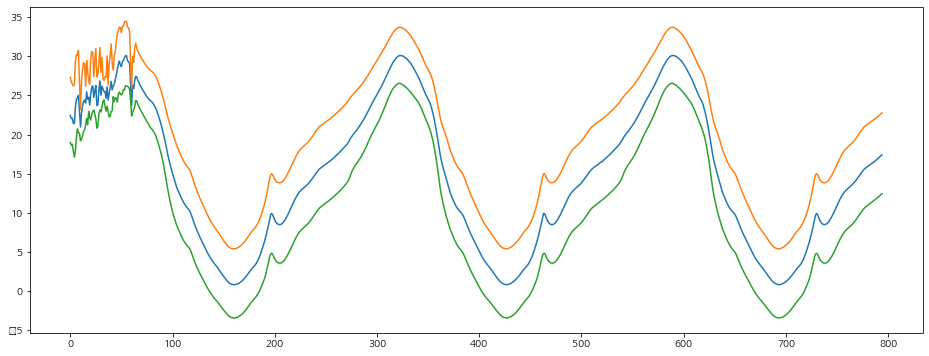

In [44]:
fig, axe = plt.subplots(figsize = (16, 6))
axe.plot(test_pred)